The cell below imports all the required libraries and defines key variables. You'll have to run cells one at a time from top to bottom. If you run them out of order, things won't work.

This notebook will closely follow the tutorial here - https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html.

In [56]:
# Make plots in the notebook so you can see them.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.integrate import quad
from scipy.optimize import curve_fit

import lightkurve # Import the lightkurve library
from lightkurve import search_targetpixelfile # From the lightkurve library, import the search_targetpixelfile method.

In [154]:
# Set up needed methods

def Carter_model(time, tc, f0, delta, T, tau):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - f0*r**2
    # T - 2*tau0*sqrt(1-b**2)
    # tau = 2*tau0*r**2/sqrt(1 - b**2)

    flux = np.zeros_like(time)

    ind = np.abs(time - tc) <= (T/2. - tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta

    ind = ((T/2. - tau/2.) < np.abs(time - tc)) & ((T/2. + tau/2.) > np.abs(time - tc))
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta + (delta/tau)*(np.abs(time[ind] - tc) - T/2. + tau/2.)

    ind = np.abs(time - tc) >= (T/2. + tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0

    return flux

def get_planet_lightcurve(planet_name):
    # Open a Target Pixel File from MAST and download one data file.
    tpf = search_targetpixelfile(planet_name).download()

    # Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
    lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).remove_nans()

    time, flux = lc.time.value, lc.flux.value
    
    return time, flux

def calc_detrended_flux(time, flux, coeffs):
    return (flux - np.polyval(coeffs, time))/np.polyval(coeffs, time)
    
def calc_sigma(detrended_flux):
    # Use the standard deviation of all the data to estimate the uncertainty
    return np.ones_like(detrended_flux)*mad(detrended_flux)

def fit_transit_ephemeris(time, trial_T0, trial_period):
    # Phase fold on the trial period
    folded_time = ((time - trial_T0) % trial_period)
    
    ret_val = Carter_model(folded_time, trial_T0, *transit_shape_params[1:])
    
    return ret_val

Let's start by plotting your data. As a general rule, you should always inspect any data you intend to use and do NOT just assume the data are fine.

/Users/bjackson/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


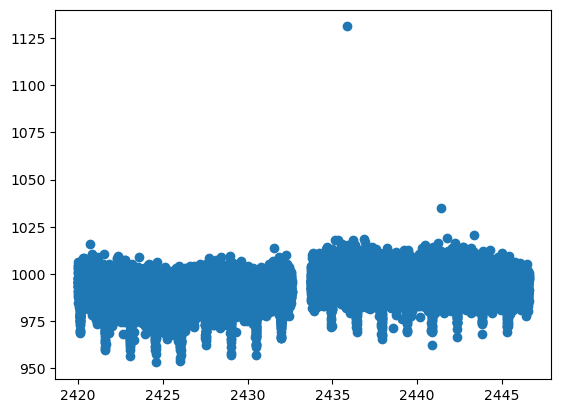

In [188]:
# Give your planet name - be sure to spell everything exactly right. Otherwise, the package won't find the data.
planet_name = "TIC 233948455"

# orbital_period = 2.47063 # https://en.wikipedia.org/wiki/TrES-2b
# orbital_period = 3.0927616 # https://en.wikipedia.org/wiki/WASP-10b
orbital_period = 1.482247063 # https://en.wikipedia.org/wiki/GSC_03949-00967
# orbital_period = 3.94150685 # https://en.wikipedia.org/wiki/XO-1b

time, flux = get_planet_lightcurve(planet_name)

plt.scatter(time, flux)

Hopefully, what you see above is a series of transit dips, probably with some scatter. 

In some cases, you may also see individual points with excursions unassociated with the transit dips, which we'll call "single-point outliers". 

There may also be some up-and-down wobbles unassocated with the transit dips. We'll call these signals "systematic noise".

In order to conduct our transit analysis, we will need to remove as much of those sources of noise as possible. 

---

### Removing Single-Point Outliers

Since the single-point outliers are big, discrete jumps, we can try to find them by using the technique we talked about in class before: calculating the derivative of the time-series and then looking for big outlier values.

(-81.914306640625, 81.7691650390625)

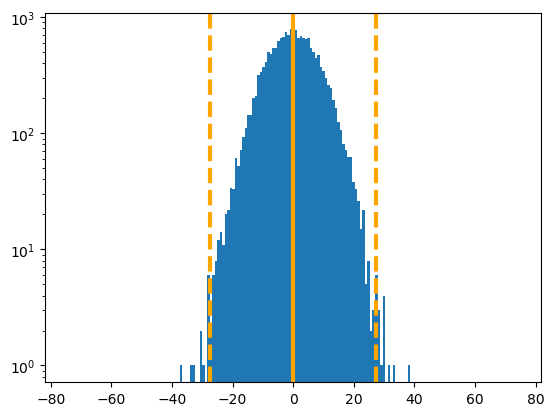

In [189]:
# Calculate the derivative
df = np.diff(flux)
num_sigma = 5.

# Calculate the median value
med = np.median(df)
# Calculate the standard deviation
std = mad(df)

# Make a histogram showing the distribution of derivative values.
plt.hist(df, bins='auto');
plt.yscale('log') # Make it easier to the outliers

# Add in lines showing the expected width of the distribution if it were just Gaussian.
plt.axvline(med, lw=3, color='orange')
plt.axvline(med - num_sigma*std, lw=3, color='orange', ls='--')
plt.axvline(med + num_sigma*std, lw=3, color='orange', ls='--')

plt.xlim([-3*num_sigma*std + med, 3*num_sigma*std + med])

Remember that we often approximate the noise in a dataset as a Gaussian distribution. That means we can *assume* a Gaussian distribution and then figure out which points in our dataset deviate from Gaussian. We'll toss those points as our single-point outliers.

If everything above worked correctly, you should see a histogram of derivative values, along with some orange lines showing the median (center) of the distribution and two dashed lines showing $\pm5 \sigma$, i.e. the maximum expected width for a Gaussian distribution. 

If the dataset were truly Gaussian, we would expect datapoints to lie more than $5 \sigma$ from the median value with a probability of about 1 in $10^12$. Since we only have a few thousand datapoints, we shouldn't expect to see any points at those distances from the median at all. That means we can safely treat points that lie outside that range as outliers.

/Users/bjackson/opt/anaconda3/lib/python3.8/site-packages/lightkurve/search.py:414: LightkurveWarning: Warning: 5 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


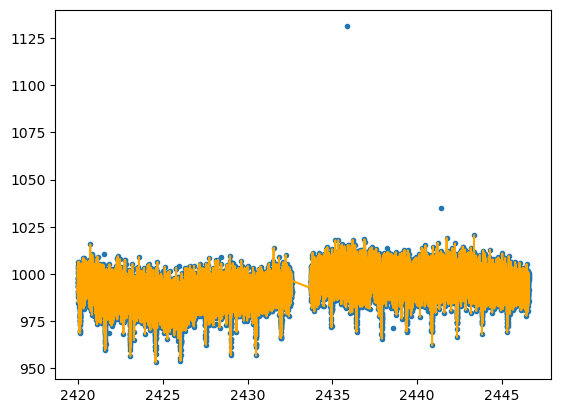

In [190]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Let's compare the original data with outliers to the processed data with outliers removed.
time, flux = get_planet_lightcurve(planet_name)
ax.plot(time, flux, marker='.', ls='')

# Find the outlier points
df = np.diff(flux)
ind = np.abs(df - med) > num_sigma*std

# Append one extra element - we have to re-jigger the data a bit since diff returns one fewer element.
ind = np.append(ind, False)
time = time[~ind][:-2]
flux = flux[~ind][:-2]
ax.plot(time, flux, color='orange')

Next, let's remove the background trends by applying a high-pass filter.

---

As discussed in class, a high-pass filter allows signals that are short in duration to stay while removing signals that are long in duration. In our case, our transit signals are short (usually only a few hours), while the systematic noise we want to remove is long (several days).

There are lots of ways to apply high-pass filters, but for our purposes, we will apply what's called a Savitzky-Golay filter (https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter), which is a series of piece-wise polynomials.

One challenge we have is that, even though the transit signals themselves are short in duration, they are still large in magnitude, so they can skew the filter we create. The way to deal with that issue is to mask out the transits, fit the polynomial to the non-transit data points, and then apply the polynomial back to the full dataset including the transit points.

But how do we mask the transits? One way is if you already know where the transits are (which we pretty much do), you can mask them directly, but what if we didn't know where the transits were? We could do the outlier-filtering again, but this time to the data directly and NOT the derivatives. 

Be careful, though: since the transits are smooth signals, we may have to adjust the number of sigma to use as the threshold. For the plot below, adjust num_sigma so that the points indicated in the plot are points within transit. Probably num_sigma will want to be between 3 and 5. 

You can will also probably need to adjust the polynomial degree (set to 1 by default) to better capture the background trends. Feel free to experiment with that as well, but it will probably want to be a number not much bigger than 1. (If you find yourself trying 10th degree polynomials, you've probably gone too far.)

/Users/bjackson/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3442: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


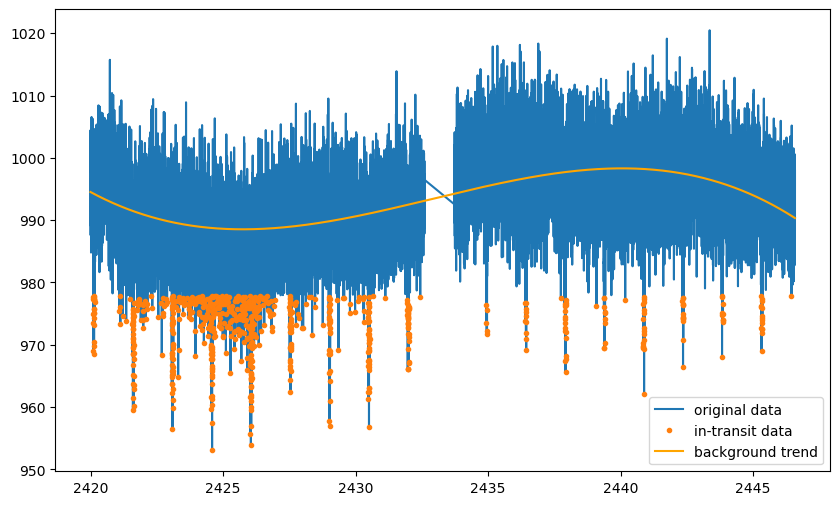

In [191]:
num_sigma = 3.
polynomial_degree = 4

med = np.median(flux)
std = mad(flux)
ind = (med - flux) > num_sigma*std

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(time, flux, label="original data")
plt.plot(time[ind], flux[ind], ls='', marker='.', label="in-transit data")

# Fit a polynomial
coeffs = np.polyfit(time[~ind], flux[~ind], polynomial_degree)
detrended_flux = calc_detrended_flux(time, flux, coeffs)

ax.plot(time, np.polyval(coeffs, time), color='orange', label="background trend")
ax.legend(loc='best')

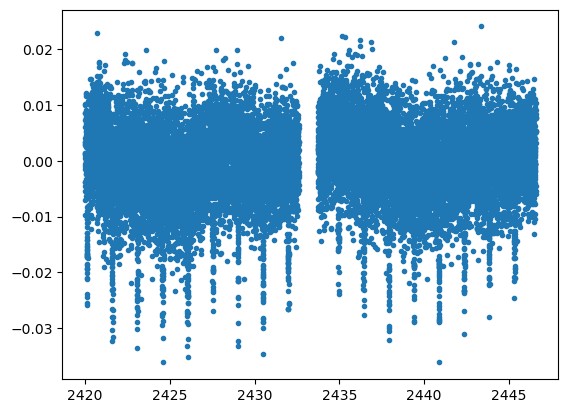

In [192]:
# And now let's plot the detrended/outlier-filtered data
plt.scatter(time, detrended_flux, marker='.')

Don't worry about perfectly removing the background trend. The analysis we're going to do is focused on the *timing* of the transit, not so much the transit shape and depth, and so it won't be that sensitive to the background trend.

---

### Fitting the model

Now we'll try to fit transit times. 

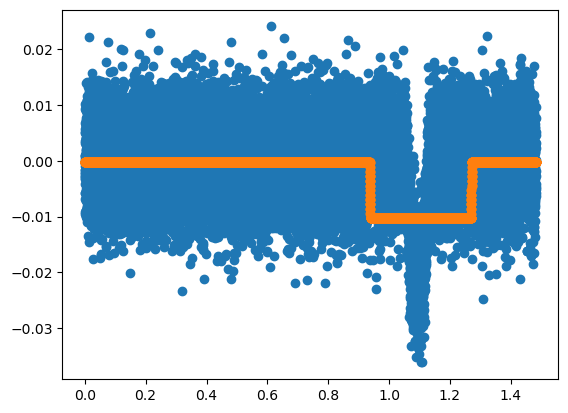

In [193]:
# Phase-folded time
folded_time = (time % orbital_period)
# Detrend the flux
detrended_flux = calc_detrended_flux(time, flux, coeffs)

# The background value is very nearly the median for all the data
background = np.median(detrended_flux)

# ratio of the planet's to the star's radius - usually about 0.1
ratio_of_planet_to_star_radius = 0.1

# Let's guess that the central transit time is the time when the flux drops to its minimum value
t0 = (time % orbital_period)[np.argmin(detrended_flux)]

# transit duration - probably a few hours, but be sure to tweak it to what your eyeball says
duration = 4./24. # Divide through 24 hours to convert from hours to days.

# Let's set our initial guesses and check them
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius**2, 
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

plt.scatter(folded_time, detrended_flux)
plt.scatter(folded_time, Carter_model(folded_time, *initial_guesses))
# plt.xlim([1., 2.])

best fit values: 1.09355, 3.93742e-06, 0.715644, -1.2168, 1.30447
best fit uncertainties: 0.000342493, 4.68601e-05, 24891, 45369.7, 45369.7


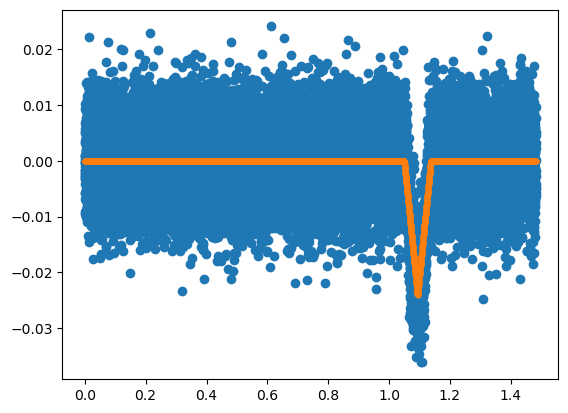

In [194]:
# Reset initial guesses
initial_guesses = np.array([t0, background, depth, 2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

# Estimate per-point uncertainties
sigma = calc_sigma(detrended_flux)

# Fit folded transit
transit_shape_params, pcov = curve_fit(Carter_model, folded_time, detrended_flux,
                      p0=initial_guesses, sigma=sigma)
transit_shape_params_unc = np.sqrt(np.diag(pcov))
print("best fit values: %g, %g, %g, %g, %g" %\
      (transit_shape_params[0], 
       transit_shape_params[1], 
       transit_shape_params[2],
       transit_shape_params[3], 
       transit_shape_params[4]))
print("best fit uncertainties: %g, %g, %g, %g, %g" % (transit_shape_params_unc[0], 
                                                      transit_shape_params_unc[1], 
                                                      transit_shape_params_unc[2], 
                                                      transit_shape_params_unc[3], 
                                                      transit_shape_params_unc[4]))

# Check the fit
plt.scatter(folded_time, detrended_flux)
plt.scatter(folded_time, Carter_model(folded_time, *transit_shape_params), marker='.')

If your model fit looks pretty good above, then congrats! You've got a decent transit shape. The next step will be to fit all the transits, one after the over, to figure out the transit ephemeris.

---

### Fitting the Transit Ephemeris

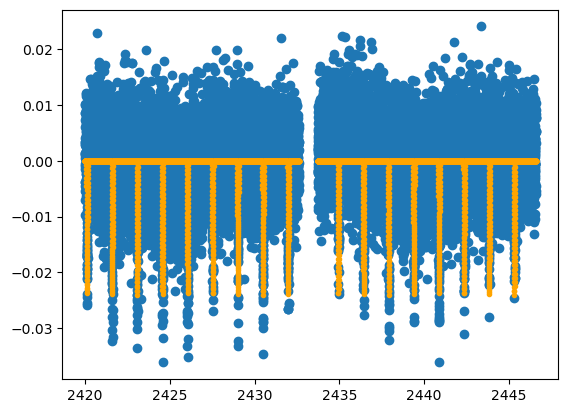

In [195]:
# Again let's set our initial guesses and check how they look
T0 = 0.5*transit_shape_params[0]
ephemeris_initial_guesses = np.array([T0, orbital_period])
initial_guess_transits = fit_transit_ephemeris(time, *ephemeris_initial_guesses)

plt.scatter(time, detrended_flux)
plt.scatter(time, initial_guess_transits, color='orange', marker='.')

best fit T0, period: 0.546775, 1.48225
best fit T0, period unc: 0.00486037, 5.9307e-06


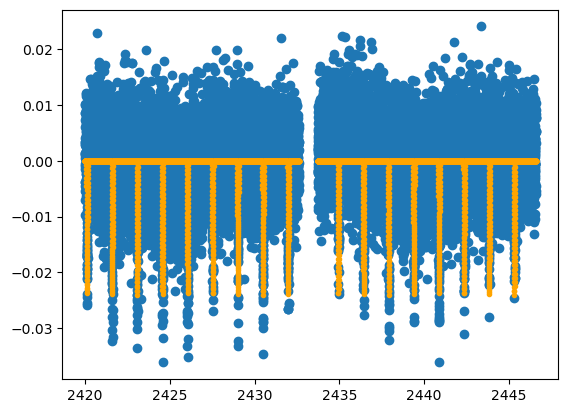

In [196]:
# Now let's do our fit.

ephemeris_fit_params, pcov = curve_fit(fit_transit_ephemeris, time, detrended_flux, 
                       p0=ephemeris_initial_guesses, sigma=sigma)
ephemeris_fit_params_unc = np.sqrt(np.diag(pcov))
print("best fit T0, period: %g, %g" % (ephemeris_fit_params[0], ephemeris_fit_params[1]))
print("best fit T0, period unc: %g, %g" % (ephemeris_fit_params_unc[0], ephemeris_fit_params_unc[1]))

plt.scatter(time, detrended_flux)
plt.scatter(time, fit_transit_ephemeris(time, *ephemeris_fit_params), color='orange', marker='.')